In [16]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from keras.datasets import mnist
import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer


from plotnine import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv


# Basic Tensorflow Operations

In [17]:
x = tf.ones(shape=(2, 1))
# x = tf.zeros(shape=(2, 1))
# x = tf.random.uniform(shape=(2, 1))
x

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [18]:
tf.square(x)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [19]:
tf.sqrt(x)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [20]:
y = tf.ones(shape = (2,1))

x + y

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [2.]], dtype=float32)>

In [21]:
z = tf.random.uniform(shape = (2,2))
tf.matmul(z,x) #2x2 * 2*1

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.8430599],
       [1.0719225]], dtype=float32)>

In [15]:
# numpy
z_np = np.ones(shape = (2,2))
z_np[1,1] = 0
z_np

array([[1., 1.],
       [1., 0.]])

In [22]:
z.shape
z[1,1] = 0

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [26]:
z_var = tf.Variable(initial_value= tf.ones(shape = (2,2)))
z_var[1,1].assign(0)
z_var

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 1.],
       [1., 0.]], dtype=float32)>

# Gradient Tape (the reason we're all here)

So far, Tensorflow is looking a lot like a fancy numpy. But it can do more than that. Most usefully, it can calculate the gradient of an expression for us with respect to any of its inputs. Even if its a VERY complex expression.



In [31]:
input_var = tf.Variable(initial_value=3.)

with tf.GradientTape() as tape:
    result = tf.square(input_var) # f(x) = x^2

gradient = tape.gradient(result, input_var) # df/dx at x = input_var

gradient

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

# Linear Classifier with Tensorflow

The example form your book (Chapter 3.5) builds a Linear Classifier using JUST Tensorflow. Let's look at the code to see how it works (luckily we won't often do this):

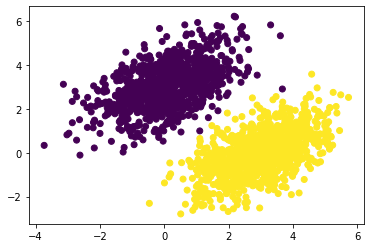

In [34]:
# generate data
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

# stack positives and negatives
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

# create y (outputs)
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

# plot data
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

Loss at step 0: 4.9020
Loss at step 1: 0.9043
Loss at step 2: 0.2738
Loss at step 3: 0.1625
Loss at step 4: 0.1358
Loss at step 5: 0.1234
Loss at step 6: 0.1141
Loss at step 7: 0.1060
Loss at step 8: 0.0986
Loss at step 9: 0.0919
Loss at step 10: 0.0858
Loss at step 11: 0.0802
Loss at step 12: 0.0752
Loss at step 13: 0.0706
Loss at step 14: 0.0664
Loss at step 15: 0.0626
Loss at step 16: 0.0592
Loss at step 17: 0.0560
Loss at step 18: 0.0532
Loss at step 19: 0.0505
Loss at step 20: 0.0482
Loss at step 21: 0.0460
Loss at step 22: 0.0440
Loss at step 23: 0.0423
Loss at step 24: 0.0406
Loss at step 25: 0.0392
Loss at step 26: 0.0378
Loss at step 27: 0.0366
Loss at step 28: 0.0355
Loss at step 29: 0.0344
Loss at step 30: 0.0335
Loss at step 31: 0.0327
Loss at step 32: 0.0319
Loss at step 33: 0.0312
Loss at step 34: 0.0306
Loss at step 35: 0.0300
Loss at step 36: 0.0295
Loss at step 37: 0.0290
Loss at step 38: 0.0286
Loss at step 39: 0.0282


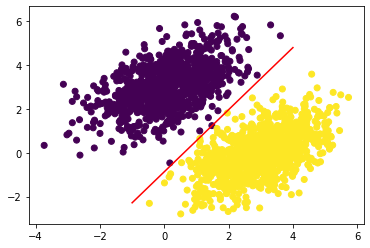

In [38]:
input_dim = 2 # number of inputs
output_dim = 1 # number of outputs

# initialize weights and bias
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

# forward pass (make predictions)
def model(inputs):
    return tf.matmul(inputs, W) + b

# loss
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

# forward and backward passes
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

# train for 40 iterations
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

# make predictions
predictions = model(inputs)

# plot final model
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)



# Basic Keras Compnents

## Model Objects
- `Model()`: an object that groups layers together to be trained and to make predictions


With `Model()` objects we can either use the **Functional API** to interface with them, or we can subclass the `Model()` object. 

### Functional API
Here, we treat layers as functions that have input tensors and output tensors. Each layer takes in the output from the previous layer. 

In [15]:
# Functional API building

inputs = kb.Input(shape = (25,))

x = kb.layers.Dense(10)(inputs)

x = kb.layers.Dense(5)(x)

x = kb.layers.Dense(2)(x)

outputs = kb.layers.Dense(1, activation = tf.nn.sigmoid)(x)

model = kb.Model(inputs = inputs, outputs = outputs)

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_52 (Dense)            (None, 10)                260       
                                                                 
 dense_53 (Dense)            (None, 5)                 55        
                                                                 
 dense_54 (Dense)            (None, 2)                 12        
                                                                 
 dense_55 (Dense)            (None, 1)                 3         
                                                                 
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________


Or we can create a new class that inherits from `Model()`. 

First we create a class that inherets from `kb.Model`, and then we create an `__init__` method that first calls the superclass' `__init__()` and then defines every layer that we need. We want this to happen in the constructor, otherwise the layers might be created more than once (which we do not want).

Then we create a `call()` method which basically defines what a forward pass of your model looks like. It takes in the default `self` arugment as well as some input to the model. This looks similar to how we defined things using the Functional API. Then we return the output of the model. 

Now we can use this subclass to build a model!
- We create inputs
- We put those inputs into our model object
- We put both into a `Model()` object


In [19]:
# we won't do this often but its nice to know

class MyModel(kb.Model):

    def __init__(self):
        # call init from inhereted class
        super().__init__()

        # create all layers here so they're only created once
        self.layer1 = kb.layers.Dense(10, input_shape = [25])
        self.layer2 = kb.layers.Dense(5)
        self.layer3 = kb.layers.Dense(2)
        self.layer4 = kb.layers.Dense(1, activation = "sigmoid")
    
    def call(self, inputs):
        # define what a forward pass looks like
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.layer3(x)
        return(self.layer4(x))

# define input shape
inputs = kb.Input(shape = (25,))

# create a model using your custom class
x = MyModel()(inputs)

# shove the inputs and outputs into a model object
my_model = kb.Model(inputs = inputs, outputs = x)

# show me the model
my_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 25)]              0         
                                                                 
 my_model_9 (MyModel)        (None, 1)                 330       
                                                                 
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________


## Sequential Object

- `Sequential()`: an object that groups layers together in a linear stack (less flexible than `Model` but typically all we need)

This is what we've done so far (and what we did in CPSC 392). We create a `Sequential()` object and give it a list of layers to add (in order).


In [5]:
# give Sequential a list of layers
my_model = kb.Sequential([
    kb.layers.Dense(10, input_shape = [25]),
    kb.layers.Dense(5),
    kb.layers.Dense(2),
    kb.layers.Dense(1, activation = "sigmoid")
])

my_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                260       
                                                                 
 dense_13 (Dense)            (None, 5)                 55        
                                                                 
 dense_14 (Dense)            (None, 2)                 12        
                                                                 
 dense_15 (Dense)            (None, 1)                 3         
                                                                 
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________


If we want to add layers dynamically, we can use `.add()` and `.pop()` to add and pop layers on/off our model. This would be useful, for example, if we wanted to loop through a list of values and add layers with those values.

In [6]:

# use .add() to dynamically add layers
my_model = kb.Sequential()
my_model.add(kb.layers.Dense(10, input_shape = [25]))
my_model.add(kb.layers.Dense(5))
my_model.add(kb.layers.Dense(2))
my_model.add(kb.layers.Dense(1, activation = "sigmoid"))

my_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 10)                260       
                                                                 
 dense_17 (Dense)            (None, 5)                 55        
                                                                 
 dense_18 (Dense)            (None, 2)                 12        
                                                                 
 dense_19 (Dense)            (None, 1)                 3         
                                                                 
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________



## Layers
Keras has many pre-defined layers that we can use (we'll learn about more of them as we learn about more model structures). For now the important layers are:

- `Dense()`: A basic densely connected layer with `units` nodes. Densely connected means that every node in the previous layer is connected to every node in the current layer. 
- `Activation()`: applies an activation function (defined by the `activation` argument) to the values coming into it. This is largely the same as using the `activation` argument in a `Dense` Layer but is useful when you want to do an operation to the layer output BEFORE applying the activation (e.g. `BatchNormalization`)
- `Input()`: A basic layer that defined the input of a model. It tells the model what the initial tensor of data that we expect to come in looks like. The `shape` argument tells the model what a *single sample* of data looks like (not a batch of samples)


`Dense` Layers tend to be the basis of most of our Neural Networks, so let's get to know the documentation a little!

- **Question** look at the [documentation](https://keras.io/api/layers/core_layers/dense/) for `Dense` layers. If I wanted to NOT have a bias for that layer, how might I tell python that?
- **Question** look at the [documentation](https://keras.io/api/layers/core_layers/dense/) for `Dense` layers. If you do not supply a value for `activation` what activation does it use?


There are many activation functions (or you can even define your own), let's look at the `activation` documentation and see what's available:

- **Question** look at the [documentation](https://keras.io/api/layers/activations/) for `activations`. What basic activation functions are available?
- Modify the code below to add a `ReLu` activation to the middle layer (either using the `activation` argument in `Dense()` or by adding an `Activation()` layer)



In [23]:
### YOUR CODE HERE ###
activated_model = kb.Sequential([
    kb.Input(shape = [25]),
    kb.layers.Dense(10), 
    kb.layers.Dense(5), # add relu here
    kb.layers.Dense(2),
    kb.layers.Dense(1, activation = "sigmoid")
])

activated_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 10)                260       
                                                                 
 dense_79 (Dense)            (None, 5)                 55        
                                                                 
 dense_80 (Dense)            (None, 2)                 12        
                                                                 
 dense_81 (Dense)            (None, 1)                 3         
                                                                 
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________


## Try It Out
Build a model with the following structure in 3 different ways:

- input size of 9 
- 2 hidden layers (with 7 and 3 nodes respectively) and `relu` activations
- output layer with 1 node and a sigmoid activation

1. Build the model using a basic `Sequential()` object and using `.add()` to add each layer. Set the activation(s) using an `Activation()` layer. 
2. Build the model using the Functional API method with `Model()`. Set the activation(s) using the `activation` argument in each layer where necessary. 
3. Build the model by subclassing `Model()`. Build all your layers in the `__init__()` method, and define a forward pass using your `call()` method. Then use the class to build your model. Set the activation(s) using the `activation` argument in each layer where necessary. 

In [ ]:
# 1. `Sequential()`

my_model1 = kb.Sequential()




In [ ]:
# 2. Functional API

inputs = kb.Input(???)

# stuff

outputs = ???

my_model2 = kb.Model(inputs = inputs, outputs = outputs)


In [ ]:
# 3. Subclass

class MyModel(kb.Model):
    def __init__(self):
        super().__init__()

        # layers
        pass

    def call(self, inputs):
        pass

## Functions

We've already used all these functions, but as a quick refresher:

- `.summary()`: call it on a model to see the structure of the model as well as information about they layers
- `.compile()`: tells python *how* to train your model, e.g. which optimizer to use, which metrics to collect, what your test/validation set is. 
- `.fit()`: train your model given the data (input and output), number of `epochs`, etc (just like sklearn but with more options)
- `.predict()`: use your model to make predictions given some input values (just like sklearn)



If you have time, download [this data set](https://www.kaggle.com/datasets/chaunguynnghunh/sepsis?select=Paitients_Files_Train.csv) and train one or all of the models you built on it (Don't include `ID` as a predictor). Don't forget to z-score and to use [`LabelBinarizer()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to change the outputs to 0's and 1's. Use whatever optimizer you want. 